# Stock Data Prediction Model using Linear Regression

## Introduction

This is a midterm coursework done for the Data Lit course of the School of AI.

The goal of the midterm was to generate stock closing price prediction using some data retrieval, cleanup and model training to generate a prediction for a freely-choosen stock symbol. For the later, I chose MongoDB, Inc. (NASDAQ: MDB).

## Setup

First thing is to install additional pip dependencies not included in Anaconda. In order to do this, run the next line in the notebook.

In [1]:
!pip install alpha_vantage delorean seaborn==0.9.0

If this is not working, manually invoke 

```
pip install alpha_vantage delorean seaborn==0.9.0
```

in a command line prompt.

### Import required modules
In order to do data cleanup, linear regression and evaluation additional imports are required.

In [2]:
# Import libraries for date handling.
import delorean
import time
from datetime import datetime

# Import libraries for general data handling.
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import pandas as pd

# Import scikit-learn model fit and evaluation.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Import Seaborn for plotting.
import seaborn as sns

### Configuration
Configuration for the stock prediction model goes here.

By default, the stock prediction is done for MongoDB, Inc. (NASDAQ: MDB) using historical data exported as CSV file for easier reproduction.
Alternatively the source data may be loaded live from AlphaVantage. In order to do so, set `USE_LIVE_DATA=True` and set your user-specific API-Key in variable `ALPHAVANTAGE_API_KEY`.

In order to evaluate the fitted model, a train / test split is used. The ratio of train / test data and random seed used for data selection are configurable using `SPLIT_POINT` respectively `SPLIT_SEED`.

In [3]:
# Stock symbol to do prediction for.
STOCK_SYMBOL = 'MDB'
# Use live data from AlphaVantage API.
USE_LIVE_DATA = False
# AlphaVantage API Key.
ALPHAVANTAGE_API_KEY = '!!! your API key goes here !!!'
# Ratio for train / test split.
SPLIT_POINT = 0.7
# Random seed for train / test data selection.
SPLIT_SEED = 42
# Path to CSV file containing historical stock data.
HISTORICAL_CSV_DATA_PATH = './mdb-historical-data.csv'

## Data Acquisition & Preparation

### Load data from source

Source can be either AlphaVantage API or local CSV file.

In [4]:
def load_daily_data_from_alpha_vantage():
    """
    Load daily data from AlphaVantage API.
    """
    print('Loading daily data from AlphaVantage API...')
    ts = TimeSeries(key=ALPHAVANTAGE_API_KEY, output_format='pandas')
    loaded_data_df, _ = ts.get_daily(STOCK_SYMBOL)
    print('Loaded daily data from AlphaVantage API.')
    return loaded_data_df

def load_daily_data_from_csv():
    """
    Load daily data from previously exported CSV.
    """
    loaded_data_df = pd.read_csv(HISTORICAL_CSV_DATA_PATH) \
        .set_index('date')
    print('Loaded daily data from historical CSV.')
    return loaded_data_df

### Data Preparation

Before being usable for predictions, the source data needs to be scrubbed a tiny bit.

For example, the source data contains attributes for stock high, low etc. whereas only the closing price is relevant for this prediction.
Additionally the data type for `date` is adjusted, additional attributes like `date_unix` for easier linear prediction and a human-readable date output for input data validation in `date_formatted` are generated from it etc.

In [5]:
def prepare_daily_data(data):
    """
    Prepare input data for prediction and visual inspection etc.
    """
    # Select only relevant columns in source.
    stock_data_only_close = data[['4. close']] \
        .reset_index() \
        .reset_index() \
        .rename({'4. close': 'close'}, axis=1)
    # Map date to date structure from DeLorean lib for easier manipulation and parsing.
    stock_data_only_close['date_delorean'] = stock_data_only_close['date'].apply(lambda date: delorean.parse(date, dayfirst=False))
    # Format date human-readable for input data validation, e.g. to prevent flipped day/month values.
    # Use ISO 8601 for uniform display.
    stock_data_only_close['date'] = stock_data_only_close['date_delorean'].apply(lambda date: date.date)
    stock_data_only_close['date_formatted'] = stock_data_only_close['date'].apply(lambda date: date.isoformat())
    stock_data_only_close['date_unix'] = stock_data_only_close['date'].apply(lambda date: time.mktime(date.timetuple()))
    # Drop unnecessary columns.
    stock_data_only_close = stock_data_only_close.drop(['date_delorean'], axis=1)
    return stock_data_only_close

In [6]:
# Load data from configured source.
loaded_data_df = load_daily_data_from_alpha_vantage() if USE_LIVE_DATA else load_daily_data_from_csv()
# Prepare input data.
prepared_data_df = prepare_daily_data(loaded_data_df)

Loaded daily data from historical CSV.


After doing data preparation let's do some exploratory data analysis to spot some obvious defects (if any) etc.

In [7]:
prepared_data_df.tail(10)

,index,date,close,date_formatted,date_unix
90,90,2019-02-25,107.92,2019-02-25,1.551049e+09
91,91,2019-02-26,98.27,2019-02-26,1.551136e+09
92,92,2019-02-27,100.48,2019-02-27,1.551222e+09
93,93,2019-02-28,101.56,2019-02-28,1.551308e+09
94,94,2019-03-01,104.16,2019-03-01,1.551395e+09
95,95,2019-03-04,96.77,2019-03-04,1.551654e+09
96,96,2019-03-05,101.03,2019-03-05,1.551740e+09
97,97,2019-03-06,97.09,2019-03-06,1.551827e+09
98,98,2019-03-07,99.46,2019-03-07,1.551913e+09
99,99,2019-03-08,99.80,2019-03-08,1.552000e+09


In [8]:
def convert_data_frame_to_vectors(prepared_data_df):
    """
    Convert input data frame to vector input
    for scikit-learn regressor.
    """
    # Uses Unix timestamp as independent variable
    # for predicition input.
    dates = prepared_data_df['date_unix'].tolist()
    prices = prepared_data_df['close'].tolist()
    dates = np.reshape(dates, (len(dates), 1))
    prices = np.reshape(prices, (len(prices), 1))
    return dates, prices

# Prepare vector inputs for model fit.
dates, prices = convert_data_frame_to_vectors(prepared_data_df)

## Model Fitting & Application

### Model Fitting

Data is split into test and train set for model evaluation, split point is configured at `SPLIT_POINT=0.7` which means 70% of data points are used for regression fitting.

In [9]:
def split_data(dates, prices):
    """
    Split input data at configured split point
    in order to generate train / test data sets.
    """
    return train_test_split(dates, prices, test_size=1-SPLIT_POINT, random_state=SPLIT_SEED)

def get_split_info_df(x_train, x_test):
    """
    Get information for train / test data set split
    for debugging / accountability reasons.
    """
    train_test_split_info_df = pd.DataFrame([
        {'Name': 'Train Set', 'Count': len(x_train)},
        {'Name': 'Test Set', 'Count': len(x_test)}
    ])
    train_test_split_info_df = train_test_split_info_df[['Name', 'Count']]
    return train_test_split_info_df

x_train, x_test, y_train, y_test = split_data(dates, prices)

In [10]:
train_test_split_info_df = get_split_info_df(x_train, x_test)
train_test_split_info_df

,Name,Count
0,Train Set,69
1,Test Set,31


Fit linear regressor using train data set.

In [11]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Model Application

In [12]:
def predict_for_dates(prediction_dates):
    """
    Predict closing stock price for
    supplied date values.
    """
    # Actually predict values.
    predicted_closes = regressor.predict(prediction_dates)
    # Map supplied date values to DataFrame for easier post-processing.
    dates_df = pd.DataFrame(prediction_dates, columns=['date_unix']).reset_index()
    # Output prediction result in column 'predicted_close' in DataFrame
    # including date as well.
    predicted_closes_df = pd.DataFrame(predicted_closes, columns=['predicted_close']) \
        .reset_index() \
        .merge(dates_df)
    return predicted_closes_df

def prepare_predicted(predicted_closes_df, prepared_data_df):
    """
    Prepare prediction output for graph plotting,
    rename labels etc.
    """
    display_data = predicted_closes_df.drop('index', axis=1).merge(prepared_data_df.drop('index', axis=1), how='left', on='date_unix')
    display_data['date'] = display_data['date_unix'].map(lambda date_unix: datetime.fromtimestamp(date_unix))
    display_data = display_data[['date', 'close', 'predicted_close']] \
        .rename({'date':'Date', 'close': 'Close (actual)', 'predicted_close': 'Close (predicted)'}, axis=1) \
        .set_index('Date')
    return display_data

In [13]:
prediction_dates = dates
predicted_closes_df = predict_for_dates(prediction_dates)

In [14]:
plotted_data_df = prepare_predicted(predicted_closes_df, prepared_data_df)
plotted_data_df.head(10)

,Close (actual),Close (predicted)
Date,,
2018-10-12,64.69,68.473966
2018-10-15,65.14,69.088879
2018-10-16,70.30,69.293850
2018-10-17,70.53,69.498821
2018-10-18,68.79,69.703792
2018-10-19,65.04,69.908763
2018-10-22,69.14,70.523676
2018-10-23,71.26,70.728647
2018-10-24,66.99,70.933618


Plot prediction and actual values using Seaborn.

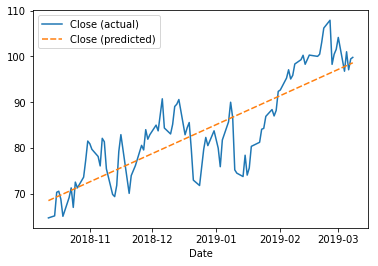

In [15]:
sns.lineplot(data=plotted_data_df)

### Model Evaluation

Lastly do some model evaluation using the train / test data sets.
For this, the so called R^2 score is used.

> In statistics, the coefficient of determination, denoted R^2 or r^2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

*Coefficient of determination. In Wikipedia. Retrieved March 9 2019, from
   https://en.wikipedia.org/wiki/Coefficient_of_determination*

The closer this value equals to 1.0, the less variance there is between the calculated regression line, e.g. less outliers between predicted and actual values are present.

In [16]:
# Generate predictions for test data set.
y_pred = regressor.predict(x_test)
# Calculate R^2 score for linear regression.
calculated_r2_score = r2_score(y_test, y_pred)

Output the calculated R^2 score for the fit model.

In [17]:
calculated_r2_score

0.7812990204519199

The calculated R^2 score for the given historical data set and the given default parameters for split etc. is ~0.7812.

During testing with the split parameters, the calculated R^2 score was between 0.6 - 0.8, this means that more sophisticated techniques like Time Series Predicition using ARIMA / Facebook's Prophet, RNNs or maybe just a multiple linear-regression should be considered for better prediction value.
Also the assumption that there is a linear correlation between date value and prediction price seems unlikely.